# Unsupervised Clustering

## Problem Definition

### Context
Manual methods to group urban neighbourhoods are at times myopic and often fail to consider every influencing factor. 

### Objective
Automatically and more intelligently group urban neighbourhoods based on data.

In [ ]:
# Colab
from google.colab import files
import io

# Data manipulation
import json 
import numpy as np
import pandas as pd

# Visualisation
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram
from bokeh.io import output_file, show, output_notebook
from bokeh.models import GeoJSONDataSource,LinearColorMapper,HoverTool,CustomJS,Dropdown,RadioButtonGroup
from bokeh.plotting import figure
from bokeh.palettes import Viridis6,Turbo256, Category20
from bokeh.layouts import column, row

# Machine Learning
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import AgglomerativeClustering, KMeans
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model

## Importing Data and Scaling

In [ ]:
# Upload CSV file and store in a Pandas DataFrame
uploaded_csv = files.upload()
df = pd.read_csv(io.BytesIO(uploaded_csv['08_centroidsnocity.csv']))
df = df.apply(pd.to_numeric, errors='raise')
df.describe().T

Saving 08_centroidsnocity.csv to 08_centroidsnocity (1).csv


count          mean           std           min           25%  \
ID_NEWLAND  29635.0  2.166479e+04  15230.098104  0.000000e+00  9.217500e+03   
Area(m2)    29635.0  8.010224e+03  38234.867996  2.000017e+02  5.096000e+02   
Recreation  29635.0  2.353509e+00      0.907119  1.000000e+00  2.000000e+00   
Airmean     29635.0  2.282755e+00      1.040221  1.000000e+00  1.000000e+00   
Foodmean    29635.0  2.822957e+00      1.815666  1.000000e+00  1.000000e+00   
Carbonom_1  29635.0  2.010327e+00      0.772674  1.000000e+00  1.745860e+00   
Habitatmea  29635.0  2.300692e+00      1.152892  1.000000e+00  1.500000e+00   
x           29635.0  5.255562e+05   5681.516285  5.119964e+05  5.210758e+05   
y           29635.0  4.744996e+06   3811.101215  4.734814e+06  4.741949e+06   

                     50%           75%           max  
ID_NEWLAND  1.827400e+04  2.998150e+04  5.301100e+04  
Area(m2)    1.456074e+03  5.761624e+03  2.164977e+06  
Recreation  2.000000e+00  3.000000e+00  5.000000e+00  
Airmean     2.000000e+00  3.000000e+00  5.000000e+00  
Foodmean    2.401198e+00  5.000000e+00  5.000000e+00  
Carbonom_1  2.000000e+00  2.010376e+00  5.000000e+00  
Habitatmea  2.000000e+00  3.000000e+00  5.000000e+00  
x           5.259951e+05  5.295448e+05  5.371800e+05  
y           4.745101e+06  4.748226e+06  4.753829e+06

In [ ]:
# Finding correlation
corr = df.corr()
c1 = corr.abs().unstack()
list(c1.sort_values(ascending=False).items())[len(df.columns)::2][:5]

[(('Habitatmea', 'Carbonom_1'), 0.8680884937173986),
 (('Foodmean', 'ID_NEWLAND'), 0.6363829875833233),
 (('ID_NEWLAND', 'Carbonom_1'), 0.4160985041720074),
 (('Habitatmea', 'ID_NEWLAND'), 0.41559931949161827),
 (('Recreation', 'Habitatmea'), 0.3917966409289397)]

In [ ]:
df.describe().T

count          mean           std           min           25%  \
ID_NEWLAND  29635.0  2.166479e+04  15230.098104  0.000000e+00  9.217500e+03   
Area(m2)    29635.0  8.010224e+03  38234.867996  2.000017e+02  5.096000e+02   
Recreation  29635.0  2.353509e+00      0.907119  1.000000e+00  2.000000e+00   
Airmean     29635.0  2.282755e+00      1.040221  1.000000e+00  1.000000e+00   
Foodmean    29635.0  2.822957e+00      1.815666  1.000000e+00  1.000000e+00   
Carbonom_1  29635.0  2.010327e+00      0.772674  1.000000e+00  1.745860e+00   
Habitatmea  29635.0  2.300692e+00      1.152892  1.000000e+00  1.500000e+00   
x           29635.0  5.255562e+05   5681.516285  5.119964e+05  5.210758e+05   
y           29635.0  4.744996e+06   3811.101215  4.734814e+06  4.741949e+06   

                     50%           75%           max  
ID_NEWLAND  1.827400e+04  2.998150e+04  5.301100e+04  
Area(m2)    1.456074e+03  5.761624e+03  2.164977e+06  
Recreation  2.000000e+00  3.000000e+00  5.000000e+00  
Airmean     2.000000e+00  3.000000e+00  5.000000e+00  
Foodmean    2.401198e+00  5.000000e+00  5.000000e+00  
Carbonom_1  2.000000e+00  2.010376e+00  5.000000e+00  
Habitatmea  2.000000e+00  3.000000e+00  5.000000e+00  
x           5.259951e+05  5.295448e+05  5.371800e+05  
y           4.745101e+06  4.748226e+06  4.753829e+06

In [ ]:
# Extract coords from data
df_coords = df[['x','y']].copy()
df_data   = df.copy().drop(['x', 'y','Area(m2)','ID_NEWLAND'], axis=1)

#The df_coords dataframe is a new dataframe (meaning that the original dataframe with all your data, df, is still in tact and not touched because of the .copy() at the end) that is used for plotting. So, if you're plotting with columns of x and y, best leave that line as;
#df_coords = df[['x', 'y']].copy()
#To then remove the columns you don't want included in the clustering, you do so in the next line...
#df_data = df.drop(['x', 'y', 'Area(m2)', 'ID_NEWLAND'], axis=1)
#Since you don't want to affect the original dataframe...
#first, copy it, then drop the unwanted columns...
#df_data = df.copy().drop(['x', 'y', 'Area(m2)', 'ID_NEWLAND'], axis=1)


# Scale data
scaler = MinMaxScaler()
scaled_df = pd.DataFrame(
    scaler.fit_transform(df_data),
    columns=df_data.columns
)

In [ ]:
# Finding correlation
corr = df.corr()
c1 = corr.abs().unstack()
list(c1.sort_values(ascending=False).items())[len(df.columns)::2][:5]

[(('Habitatmea', 'Carbonom_1'), 0.8478772316252631),
 (('ID_NEWLAND', 'Foodmean'), 0.5932131400045451),
 (('Habitatmea', 'Recreation'), 0.44612478831776353),
 (('Carbonom_1', 'Recreation'), 0.41308955820107657),
 (('Foodmean', 'Airmean'), 0.36890110505043)]

## Approach 1: Agglomerative Clustering

In [ ]:
# Build and compile models
ac_model = AgglomerativeClustering(
    n_clusters=6,
    # n_clusters=None,
    # distance_threshold=0
)

In [ ]:
# Train models
ac_model.fit(scaled_df)

AgglomerativeClustering(n_clusters=6)

In [ ]:
# Get classes
ac_model.labels_


array([5, 5, 3, ..., 4, 1, 1])

In [ ]:
df_cluster = pd.DataFrame(ac_model.labels_)
 

In [ ]:
df_cluster

0
0      5
1      5
2      3
3      2
4      3
...   ..
29630  1
29631  4
29632  4
29633  1
29634  1

[29635 rows x 1 columns]

In [ ]:
df_cluster0 = df.loc[df_cluster[0]==1]

In [ ]:
df_cluster0.describe().T

count          mean           std           min           25%  \
ID_NEWLAND  6021.0  3.964451e+04  12650.760340  3.140000e+02  2.929900e+04   
Area(m2)    6021.0  2.956508e+03   7841.272383  2.000344e+02  3.890382e+02   
Recreation  6021.0  2.261114e+00      0.842892  1.000000e+00  2.000000e+00   
Airmean     6021.0  1.402605e+00      0.586462  1.000000e+00  1.000000e+00   
Foodmean    6021.0  1.019139e+00      0.108396  1.000000e+00  1.000000e+00   
Carbonom_1  6021.0  1.241094e+00      0.406567  1.000000e+00  1.000000e+00   
Habitatmea  6021.0  1.204596e+00      0.403146  1.000000e+00  1.000000e+00   
x           6021.0  5.249757e+05   3690.160976  5.121732e+05  5.236613e+05   
y           6021.0  4.744746e+06   2660.727779  4.736296e+06  4.743225e+06   

                     50%           75%           max  
ID_NEWLAND  4.507400e+04  4.881600e+04  5.301100e+04  
Area(m2)    8.467468e+02  2.255614e+03  1.498380e+05  
Recreation  2.000000e+00  2.000000e+00  5.000000e+00  
Airmean     1.000000e+00  2.000000e+00  5.000000e+00  
Foodmean    1.000000e+00  1.000000e+00  2.454545e+00  
Carbonom_1  1.000000e+00  1.357143e+00  3.175000e+00  
Habitatmea  1.000000e+00  1.022573e+00  3.250000e+00  
x           5.256576e+05  5.273413e+05  5.352850e+05  
y           4.744463e+06  4.745869e+06  4.752518e+06

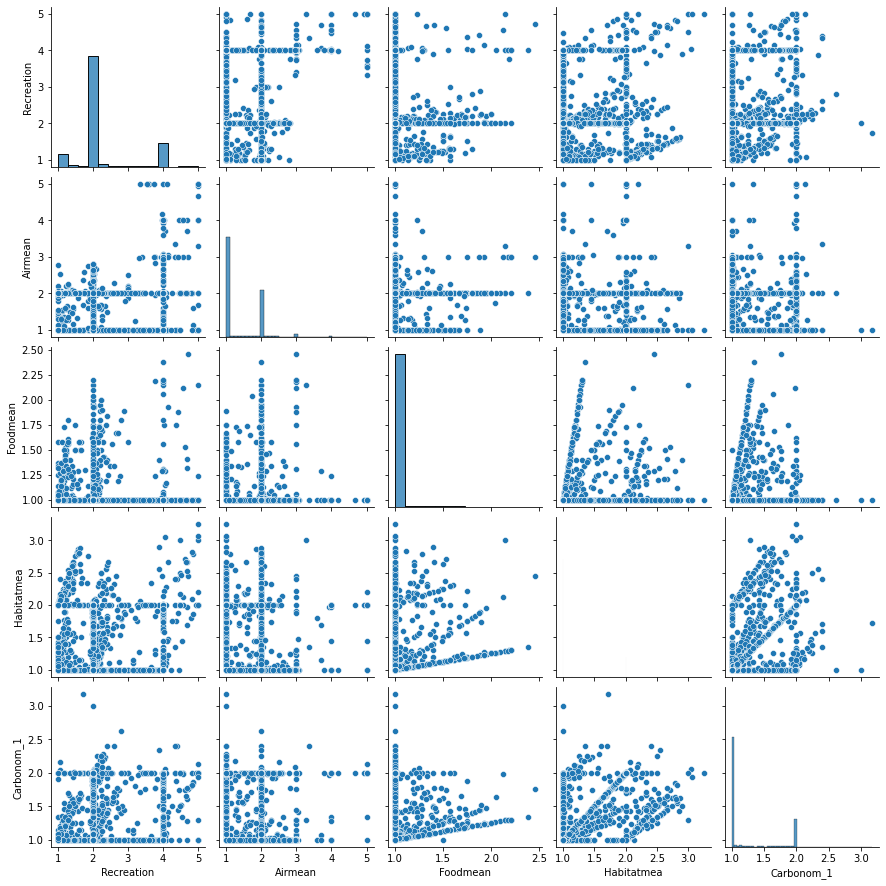

In [ ]:
sns.pairplot(df_cluster0[['Recreation','Airmean','Foodmean','Habitatmea','Carbonom_1']])

In [ ]:
#def visualise_agglomerative_clustering(model, **kwargs):
#     counts = np.zeros(model.children_.shape[0])
#     n_samples = len(model.labels_)
#    for i, merge in enumerate(model.children_):
#         current_count = 0
#        for child_idx in merge:
#            if child_idx < n_samples:
#                current_count += 1  # leaf node
#             else:
#                 current_count += counts[child_idx - n_samples]
#         counts[i] = current_count
#     linkage_matrix = np.column_stack([
#         model.children_,
#         model.distances_,
#         counts
#     ]).astype(float)
#     dendrogram(linkage_matrix, **kwargs)

In [ ]:
# visualise_agglomerative_clustering(ac_model)

In [ ]:
def map_clustering_results(coords, model):
    labels = model.labels_
    for label in np.unique(labels):
        x = coords['x'].to_numpy()[labels == label]
        y = coords['y'].to_numpy()[labels == label]
        plt.scatter(x, y, label=model.labels_)

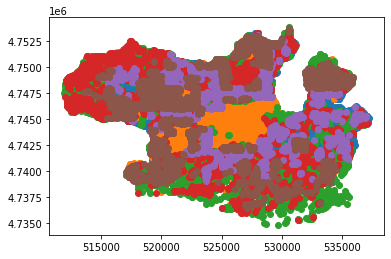

In [ ]:
map_clustering_results(df_coords, ac_model)

In [ ]:
df_cluster0 = df.loc[df_cluster[0]==1]

## Approach 2: K-Means Clustering

In [ ]:
# Build and compile model
km_model = KMeans(
    n_clusters=6
)

In [ ]:
# Train model
km_model.fit(scaled_df)

KMeans(n_clusters=6)

In [ ]:
km_model.labels_

array([5, 5, 5, ..., 3, 1, 1], dtype=int32)

In [ ]:
df_clusterkmeans = pd.DataFrame(km_model.labels_)

In [ ]:
df_clusterkmeans

0
0      5
1      5
2      5
3      2
4      4
...   ..
29630  1
29631  3
29632  3
29633  1
29634  1

[29635 rows x 1 columns]

In [ ]:
df_clusterkmeans0 = df.loc[df_clusterkmeans[0]==3]

In [ ]:
df_clusterkmeans0.describe().T

count          mean           std           min           25%  \
ID_NEWLAND  2985.0  3.387622e+04  14458.160989  4.200000e+01  2.367600e+04   
Area(m2)    2985.0  2.798818e+03   6708.884669  2.005693e+02  4.517142e+02   
Recreation  2985.0  2.124097e+00      0.565176  1.000000e+00  2.000000e+00   
Airmean     2985.0  3.343639e+00      0.563886  2.333333e+00  3.000000e+00   
Foodmean    2985.0  1.126761e+00      0.368729  1.000000e+00  1.000000e+00   
Carbonom_1  2985.0  1.233695e+00      0.424701  1.000000e+00  1.000000e+00   
Habitatmea  2985.0  1.158053e+00      0.373266  1.000000e+00  1.000000e+00   
x           2985.0  5.268096e+05   4860.686905  5.151363e+05  5.237566e+05   
y           2985.0  4.745068e+06   2989.095970  4.739027e+06  4.742201e+06   

                     50%           75%           max  
ID_NEWLAND  3.035900e+04  4.794500e+04  5.300900e+04  
Area(m2)    9.675883e+02  2.537929e+03  1.672119e+05  
Recreation  2.000000e+00  2.000000e+00  5.000000e+00  
Airmean     3.000000e+00  4.000000e+00  5.000000e+00  
Foodmean    1.000000e+00  1.000000e+00  3.000000e+00  
Carbonom_1  1.000000e+00  1.300000e+00  4.000000e+00  
Habitatmea  1.000000e+00  1.042553e+00  3.333333e+00  
x           5.264163e+05  5.300516e+05  5.369199e+05  
y           4.745238e+06  4.747498e+06  4.753100e+06

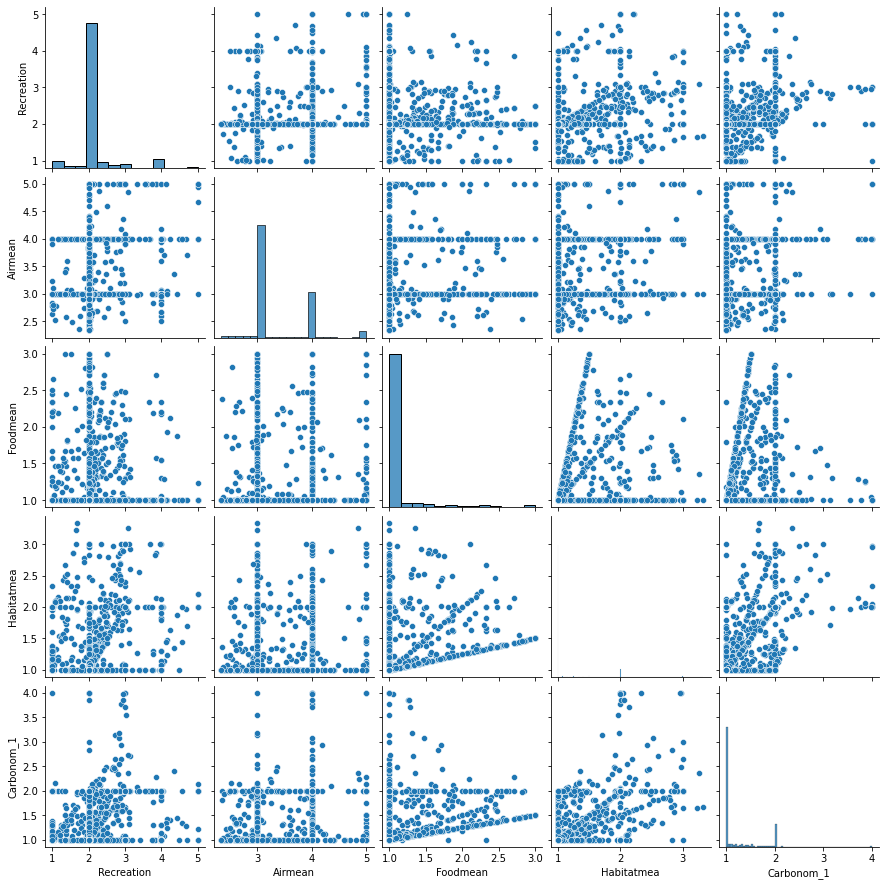

In [ ]:
sns.pairplot(df_clusterkmeans0[['Recreation','Airmean','Foodmean','Habitatmea','Carbonom_1']])

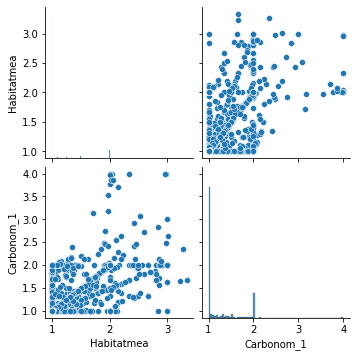

In [ ]:
sns.pairplot(df_clusterkmeans0[['Habitatmea','Carbonom_1']])

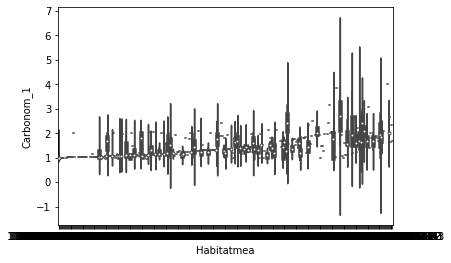

In [ ]:
sns.violinplot(y = df_clusterkmeans0['Carbonom_1'], x = df_clusterkmeans0['Habitatmea'])

In [ ]:
def map_clustering_results(coords, model):
    labels = model.labels_
    for label in np.unique(labels):
        x = coords['x'].to_numpy()[labels == label]
        y = coords['y'].to_numpy()[labels == label]
        plt.scatter(x, y, label=model.labels_)

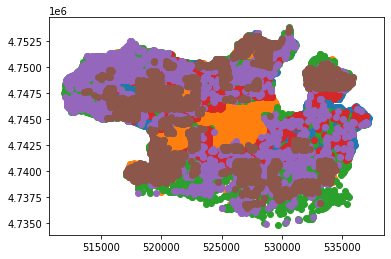

In [ ]:
map_clustering_results(df_coords, km_model)

## Approach 3: Autoencoders and K-Means Clustering

"In the past, dimensionality reduction [...] and clustering have been treated separately, and sequentially applied on data (Ding and He, 2004; Tian et al., 2014; Trigeorgis
et al., 2014). However, recent research has shown that jointly optimizing for both problems can achieve decent results (Song et al., 2013; Xie et al., 2016; Yang et al., 2016a;b; Li et al., 2017)."

From ICLR 2018 conference paper under double-blind review. [link](https://openreview.net/pdf/e03d46184bc51997e6756874bdcba2cedcfa8606.pdf).

In [ ]:
# Autoencoder
class Autoencoder(Model):

    def __init__(self, input_output_shape, latent_shape):
        super(Autoencoder, self).__init__()
        
        self.encoder = keras.Sequential([
            layers.Dense(8, activation='relu', input_shape=(input_output_shape,)),
            layers.Dense(4, activation='relu'),
            layers.Dense(latent_shape, activation='sigmoid')
        ])
        
        self.decoder = keras.Sequential([
            layers.Dense(4, activation='relu', input_shape=(latent_shape,)),
            layers.Dense(8, activation='relu'),
            layers.Dense(input_output_shape, activation='sigmoid')
        ])
    
    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

def see_final_loss(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch
    return hist.tail()

def plot_loss(history):
    plot = plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Error')
    plt.legend()
    plt.grid(True)
    return plot

# Build AE model
ae_model = Autoencoder(
    input_output_shape=scaled_train_df.shape[1],
    latent_shape=2
)

# Compile AE model
ae_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss=keras.losses.MSE
)

In [ ]:
# Training AE
ae_history = ae_model.fit(
    x=scaled_train_df,
    y=scaled_train_df,
    epochs=50,
    validation_split=0.2
)

Epoch 1/50
51/51 [==============================] - 3s 32ms/step - loss: 0.1803 - val_loss: 0.1617
Epoch 2/50
51/51 [==============================] - 0s 8ms/step - loss: 0.1496 - val_loss: 0.1233
Epoch 3/50
51/51 [==============================] - 0s 6ms/step - loss: 0.0999 - val_loss: 0.0729
Epoch 4/50
51/51 [==============================] - 0s 6ms/step - loss: 0.0518 - val_loss: 0.0406
Epoch 5/50
51/51 [==============================] - 0s 7ms/step - loss: 0.0298 - val_loss: 0.0317
Epoch 6/50
51/51 [==============================] - 0s 6ms/step - loss: 0.0236 - val_loss: 0.0288
Epoch 7/50
51/51 [==============================] - 0s 4ms/step - loss: 0.0214 - val_loss: 0.0277
Epoch 8/50
51/51 [==============================] - 0s 6ms/step - loss: 0.0203 - val_loss: 0.0268
Epoch 9/50
51/51 [==============================] - 0s 6ms/step - loss: 0.0197 - val_loss: 0.0264
Epoch 10/50
51/51 [==============================] - 0s 5ms/step - loss: 0.0194 - val_loss: 0.0262
Epoch 11/50
51/51 

In [ ]:
# Build and compile KM model
ae_km_model = KMeans(
    n_clusters=3
)

In [ ]:
# Train model
encoded_x = ae_model.encoder(scaled_train_df.to_numpy())
ae_km_model.fit(encoded_x)

KMeans(n_clusters=3)

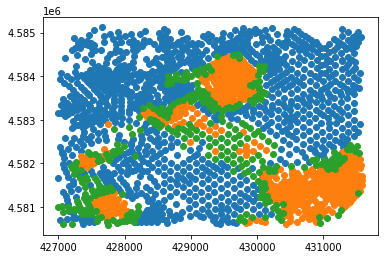

In [ ]:
map_clustering_results(df_coords, ae_km_model)

## Interactive Visualisation



In [ ]:
uploaded_json = files.upload()

Saving map.json to map.json


In [ ]:
# Collect clustering results
additional_attributes = {
    "Agglomerative": ac_model.labels_,
    "K-Means": km_model.labels_,
    "Autoencoder + K-Means": ae_km_model.labels_
}

In [ ]:
# Define output file for bokeh
output_notebook()

# Load file as json
json_string =  uploaded_json[list(uploaded_json.keys())[0]]
data = json.loads(json_string)

# Collect attributes
attributes = list(data["features"][0]["properties"].keys())
data_points = len(data["features"])

# Add results to geoJSON
for i in range(len(data["features"])):
  for new_key in additional_attributes:
    data["features"][i]["properties"][new_key] = str(additional_attributes[new_key][i])

# Create bokeh geojsonDataSource
geo_source = GeoJSONDataSource(geojson=json.dumps(data))

# Define a color scheme
# Refer to the following link for more palletes:
# https://docs.bokeh.org/en/latest/docs/reference/palettes.html
color_mapper = LinearColorMapper(palette=Turbo256)

# Define interaction tools
TOOLS = "pan,wheel_zoom,box_zoom,reset,hover,save"

# Set plot properties
p = figure(
    title="blocks",
    x_axis_location=None,
    y_axis_location=None,
    tools=TOOLS,
    width=800,
    height=400
)

# Draw polygons
p.patches(
    'xs',
    'ys',
    fill_alpha=0.7,
    fill_color={'field': 'Accidents','transform': color_mapper},
    line_color='grey',
    line_width=0.5,
    source=geo_source
)

# Create tooltip tool
hover = p.select_one(HoverTool)
hover.point_policy = "follow_mouse"
hover.tooltips = [("Accidents:", "@Accidents")]

# Dropdown menu + callback to change colors 
dropdown = Dropdown(
    label="Dropdown button",
    menu=attributes,
    width=200,
    sizing_mode="fixed"
)
dropdown.js_on_event(
    "menu_item_click",
    CustomJS(
        args=dict(
            g=p,
            color_mapper=color_mapper,
            hover_tool=hover
        ),
        code="""
            var selected_indicator = this.item
            g.attributes.renderers[0].attributes.glyph.fill_color = {'field': selected_indicator, 'transform': color_mapper}
            hover_tool.tooltips[0] = [selected_indicator, '@'+selected_indicator]
            g.title.text = "blocks -" + " " +selected_indicator
        """
    )
)

# Dropdown menu + callback to change colors 
radio_button_group = RadioButtonGroup(
    labels=list(additional_attributes.keys()), active=None
)
radio_button_group.js_on_click(
    CustomJS(
        args=dict(
            g=p,
            color_mapper=color_mapper,
            hover_tool=hover,
            attribute_names=list(additional_attributes.keys())
        ),
        code="""
            var selected_indicator = attribute_names[this.active]
            g.attributes.renderers[0].attributes.glyph.fill_color = {'field': selected_indicator, 'transform': color_mapper}
            hover_tool.tooltips[0] = [selected_indicator, '@'+selected_indicator]
            g.title.text = "blocks -" + " " +selected_indicator
        """
    )
)

show(column(p,row(dropdown,radio_button_group, sizing_mode="stretch_width")))